# Part-1: Gradient Descent and Genetic Algorithms applied to  PID Controller

## Introduction

This is an attempt to implement a simple gradient descent and genetic algorithms for PID (Proportional, Integral, Derivative) controllers in the hope that they tune the PID controller finding the optimum coefficients.

For the sake of simplicity, let's keep the scenario as simple as possible. Let's consider a cube on the ground and we would like to raise it to a certain height with a contrived robotic arm, or anything else that could apply the required variable force to the cube. The force sould change in time until the cube settles at a desired level as fast as possible.

PID coefficients play an important role to determine correct force-time relation to realize such a control system.
We are going to plot some force, velocity and height graphs to demonstrate how these coeffecients affect the system.

Symbols and variables used in this example are given in the table below.

| Symbol        | Explanation                    |
|:-------------:|:------------------------------:|
| $h_d(t)$      | desired height                 |
| $h_m(t)$      | measured height                |
| $h_e(t)$      | height error                   |
| $v_m(t)$      | measured velocity              |
| $v_e(t)$      | velocity error                 |
| $a(t)$        | measured acceleration          |
| $F(t)$        | estimated force                |
| $K_{hp}$      | height control p coefficient   |
| $K_{hi}$      | height control i coeeficient   |
| $K_{hd}$      | height control d coeeficient   |

Following drawing illustrates the scenario.
![scenario](../img/simple_lifter.png)

$F(t)$ is applied by a `Lifter`. An accelerometer sensor measures the acceleration caused by the force. $v_m(t)$ is calculated by integrating $a(t)$ over time. We obtain the $h_m(t)$ by integrating $v_m(t)$ and feed it back into the system. We estimate a new force value using the measured height and desired height.

Diagram below depicts the overall control loop. 

![control_diagram](../img/simple_lifter_pid.png)

## PID Formulation in Discrete Time

Let's figure out how we impelement a PID loop. Well known continuous time PID formulation given below.

$$\begin{align}
h_e(t) & = h_d(t) - h_m(t) \\
P(t) & = K_{hp}h_e(t) \\
I(t) & = K_{hi}\int_{0}^{t}h_e(\tau)\mathrm{d}\tau \\
D(t) & = K_{hd}\frac{h_e(t)}{dt} \\
F(t) & = P(t) + I(t) + D(t)
\end{align}$$

Note that these are all in continuous time domain. We have to work in discrete time.
Here is how one could get into the discrete time.

$$\begin{align}
h_e(nT) & = h_d(nT) - h_m(nT) \\
P(nT) & = K_{hp}h_e(nT) \\
I(nT) & = I\big((n-1)T\big) + K_{hi}h_e(nT)T \\
D(nT) & = K_{hd}\frac{h_e(nT) - h_e\big((n-1)T)\big)}{T} \\
F(nT) & = P(nT) + I(nT) + D(nT)
\end{align}$$

where $n = 1,2,3,\dots$ and $T$ is the sampling period or the period we run the PID controller.

Let's be more realistic. We can't integrate all the error, it might result in a huge force that our physical *Lifter* cannot handle. We need to somehow constrain it.

$$\begin{align}
h_e[n] & = h_d[n] - h_m[n] \\
P[n] & = K_{hp}h_e[n] \\
I[n] & = 
 \begin{cases}
      I[n-1] + K_{hi}h_e[n]T, & \text{if } -I_{windup} < I[n] < I_{windup} \\
      -I_{windup}, & \text{else if }    I[n]  \leq -I_{windup}\\
      I_{windup}, & \text{otherwise } \\
   \end{cases} \\
D[n] & = K_{hd}\frac{(h_e[n] - h_e[n-1])}{T} \\
F[n] & =
 \begin{cases}
      P[n] + I[n] + D[n], & \text{if } -F_{windup} < F[n] < F_{windup} \\
      -F_{windup}, & \text{else if }    F[n]  \leq -F_{windup}\\
      F_{windup}, & \text{otherwise } \\
\end{cases} \\
\end{align}$$

$I[n]$ and $F[n]$ look a little scary above, but [Wikipedia](https://en.wikipedia.org/wiki/Integral_windup)' s example is pretty nice to explain windup guards.
>Integral windup particularly occurs as a limitation of physical systems, compared with ideal systems, due to the ideal output being physically impossible (process saturation: the output of the process being limited at the top or bottom of its scale, making the error constant). For example the position of a valve cannot be any more open than fully open and also cannot be closed any more than fully closed. In this case integral windup can actually involve the integrator being turned off for periods of time until the response falls back into an acceptable range.

Consider the plots of two integration methods, the Right Riemann Sum and Trapezoid Sums below.

In [2]:
# Let printing work the same in Python 2 and 3
from __future__ import print_function
# Import required modules in this notebook
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import interact, FloatText
from matplotlib.patches import Polygon

<IPython.core.display.Javascript object>


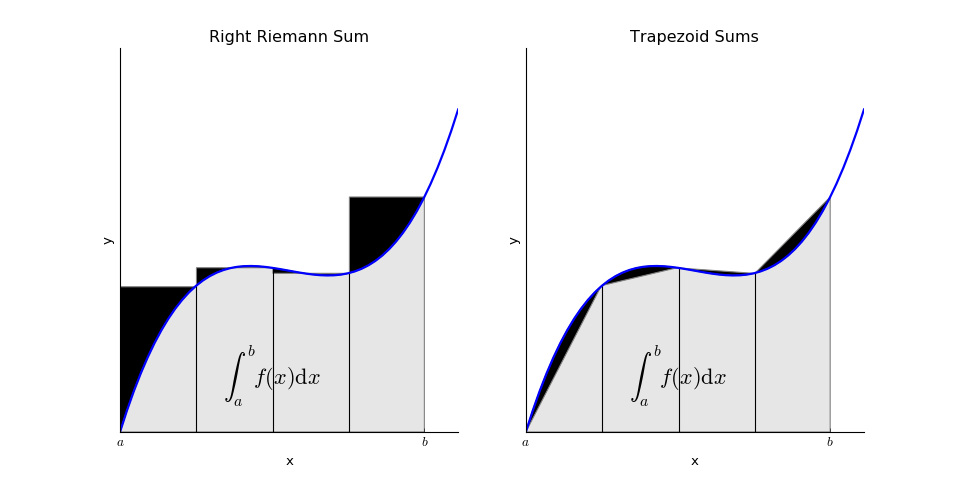

In [2]:
# See http://www.zweigmedia.com/RealWorld/integral/numint.html for more details
def func(x):
    return (x - 3) * (x - 5) * (x - 7) + 105


a, b = 0, 9  # integral limits
x = np.linspace(0, 10)
y = func(x)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=plt.figaspect(0.5))

################# Axes 1 ####################
ax1.set_title('Right Riemann Sum')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax1.plot(x, y, 'b', linewidth=2)
ax1.set_ylim(ymin=0)

# Make the shaded region
ix = np.linspace(a, b, 200)
iy = func(ix)
verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax1.add_patch(poly)
ix.shape = (4, 50)
iy.shape = (4, 50)
for i, j in zip(ix, iy):
    verts = list(zip(i, j)) + [(i[0], j[-1])]
    poly = Polygon(verts, facecolor='0.0', edgecolor='0.5')
    ax1.add_patch(poly)
    verts = [(i[0], 0), (i[0], j[0])]
    poly = Polygon(verts, facecolor='0.0', edgecolor='0.0')
    ax1.add_patch(poly)
    
ax1.text(0.5 * (a + b), 30, r"$\int_a^b f(x)\mathrm{d}x$",
         horizontalalignment='center', fontsize=20)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')

ax1.set_xticks((a, b))
ax1.set_xticklabels(('$a$', '$b$'))
ax1.set_yticks([])

################# Axes 2 ####################

ax2.set_title('Trapezoid Sums')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax2.plot(x, y, 'b', linewidth=2)
ax2.set_ylim(ymin=0)

# Make the shaded region
ix = np.linspace(a, b, 200)
iy = func(ix)
verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax2.add_patch(poly)
ix.shape = (4, 50)
iy.shape = (4, 50)
for i, j in zip(ix, iy):
    verts = list(zip(i, j))
    poly = Polygon(verts, facecolor='0.0', edgecolor='0.5')
    ax2.add_patch(poly)
    verts = [(i[0], 0), (i[0], j[0])]
    poly = Polygon(verts, facecolor='0.0', edgecolor='0.0')
    ax2.add_patch(poly)
    
plt.text(0.5 * (a + b), 30, r"$\int_a^b f(x)\mathrm{d}x$",
         horizontalalignment='center', fontsize=20)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')

ax2.set_xticks((a, b))
ax2.set_xticklabels(('$a$', '$b$'))
ax2.set_yticks([])
plt.show()

Judging from the plots, one can conclude that integrator is prone to saturate the system as it accumulates the area under the curve. Because we are working in discrete time, integrator also accumulates the dark black areas making it proner to the saturation. Clearly, the error is greater in Right Riemann Sum.

## PID Implementation

`pid` function takes coefficients $K_{hp}$, $K_{hi}$, $K_{hd}$ and desired height $h_d$ as arguments, and returns $h_d(t)$, $h_m(t)$, $v_m(t)$, $F(t)$, $t$, so that we can plot the graphs to observe the changes in time domain. We can also derive a fitness function for genetic algortihm and a cost function for gradient descent algorithm using the data returned by the `pid` function.

In [3]:
def pid(Khp, Khi, Khd, h_d):
    
    # Time
    freq = 1000.0 # Hz
    T = 1.0/freq
    t = np.arange(0, 15, T) # 15 seconds with `freq` Hz

    # Plot data
    hd  = np.zeros_like(t)  # meter(m)
    hm  = np.zeros_like(t)  # meter(m) 
    vm = np.zeros_like(t)   # m/s   
    F  = np.zeros_like(t)  # Newton(N) = kg.m/s^2
   
    # Weight
    m   = 1.0                # kg
    g   = 9.8                # m/s^2

    # Measurement
    accel_measured_sum = 0.0
    accel_measured_cnt = 0
    velocity = 0.0
    height = 0.0

    # PID variables for I and D
    Ihe = 0.0
    he_prev = 0
    
    # Data to be saved
    force = 0.0
    h_m = 0.0
    v_m = 0.0

    for n,_ in enumerate(t):
        # 1000 Hz system loop
        # read sensors etc...
        accel_measured_sum +=  -g + force/m
        accel_measured_cnt += 1

        # 100 Hz loop
        if n % 10 == 0:
            period = T*10.0
            # estimate sensor readings
            accel = accel_measured_sum / accel_measured_cnt
            accel_measured_sum = 0
            accel_measured_cnt = 0
            #v = velocity
            velocity += accel * period
            #velocity = (velocity + v) * 0.5
            # ^ Also give this a try (trapezoidal rule)
            # see http://www.zweigmedia.com/RealWorld/integral/numint.html
            height += velocity * period
            if height < 0:
                h_m = 0
                v_m = 0
            else:
                h_m = height
                v_m = velocity
                
            h_e = h_d - h_m
            #I = Ive
            Ihe += Khi*h_e*period
            #Ive = (Ive + I)*0.5
            # ^ Also give this a try (trapezoidal rule)
            # see http://www.zweigmedia.com/RealWorld/integral/numint.html
            Ihe = min(Ihe, 15)
            Ihe = max(Ihe,-15)
            force = Khp*h_e + Ihe + Khd*(h_e - he_prev)/period
            force = min(force, 15)
            force = max(force,-15)
            he_prev = h_e
        
        # Save for plotting
        F[n] = force
        hd[n] = h_d
        hm[n] = h_m
        vm[n] = v_m
        
    return (hd, hm, vm, F, t)

## Plotting

Let's plot the data returned from the `pid` function.

<IPython.core.display.Javascript object>


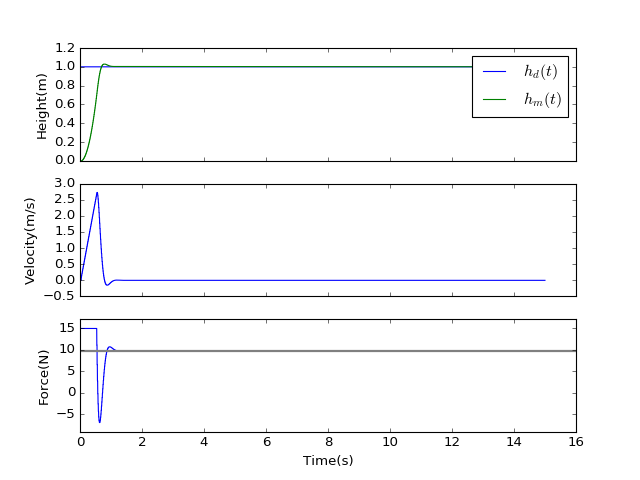

<function __main__.pid_plot>

In [12]:
def pid_plot(Khp, Khi, Khd, h_d):
    (hd, hm, vm, F, t) = pid(Khp, Khi, Khd, h_d)
    fig, axes = plt.subplots(nrows=3, sharex=True)
    axes[0].plot(t, hd, label='$h_d(t)$')
    axes[0].plot(t, hm, label='$h_m(t)$')
    axes[0].set_ylabel('Height(m)')
    axes[0].legend()
    axes[1].plot(t, vm)
    axes[1].set_ylabel('Velocity(m/s)')
    axes[2].plot(t, F)
    axes[2].set_ylabel('Force(N)')
    axes[2].set_xlabel('Time(s)')
    axes[2].axhline(9.8, color='gray', linewidth=2)
    axes[2].margins(y=0.1)
    plt.show()
    
interact(pid_plot,
              Khp=FloatText(161.4, description=r'$K_{hp}$'),
              Khi=FloatText(24.6, description=r'$K_{hi}$'),
              Khd=FloatText(16.5, description=r'$K_{hd}$'),
              h_d=FloatText(1.0, description=r'$h_d$'))
#pid_plot(161.40858917220115, 24.677859777719057, 16.526127871556596, 1.0)

## Animation

It is also nice to see the animation of the motion with different PID coefficients.

In [ ]:
(hd, hm, vm, F, t) = pid(46.647827249166696, 20.5239622863242, 10.423771462678062, 1.0)
h = hd[-1]
verts = np.array([[0.0, 0.0], [0.0, h*0.1], [h*0.1, h*0.1], [h*0.1, 0.0]])
fig, ax = plt.subplots(figsize=plt.figaspect(2.0))
square = ax.add_patch(plt.Polygon(verts, fc='g', ec='w', alpha=0.5))
def init_animation():
    ax.grid(True)
    ax.axhline(y=h, linewidth=1, color='g')
    ax.axis('equal')
    ax.set_ylabel('Height(m)')
    ax.set_xlim(-h*0.1, h*0.2)
    ax.set_ylim(0, 1.5*h)

def animate(height):
        verts[0][1] = height
        verts[1][1] = height + h*0.1
        verts[2][1] = height + h*0.1
        verts[3][1] = height
        square.set_xy(verts)
        return square

ani = matplotlib.animation.FuncAnimation(fig, animate, hm[0:-1:200], init_func=init_animation, blit=True)
#ani.save('/tmp/pid_animation.gif', writer='imagemagick', fps=30)
plt.show()

## Gradient Descent Algorithm for PID Tuning

Gradient Descent Algorithm can be [used](http://andrew.gibiansky.com/blog/physics/quadcopter-dynamics/) to find some good coefficients, but they are not guaranteed to be the best ones. Let's define a coefficient vector $\vec{\mathbf{C}}_n$ and a cost function $J(\vec{\mathbf{C}}_n)$ which evaluates how good/bad the coeffiecients in $\vec{\mathbf{C}}_n$ are. Then we can estimate a new vector $\vec{\mathbf{C}}_{n+1}$ which should perform better than $\vec{\mathbf{C}}_{n}$.

$$\begin{align}
\vec{\mathbf{C}}_n & = (K_{hp}, K_{hi}, K_{hd}) \\
J(\vec{\mathbf{C}}_n) & = \frac{1}{t_f-t_0}\int_{t_0}^{t_f}h_e^2(t)\mathrm{d}t \\
\vec{\mathbf{C}}_{n+1} & = \vec{\mathbf{C}}_n - \alpha \nabla J(\vec{\mathbf{C}}_n)
\end{align}$$

where $\alpha$ is the step size.

$\nabla J(\vec{\mathbf{C}}_n)$ is as follows by definition,

$$\begin{align}
\nabla J(\vec{\mathbf{C}}_n) & = \bigg(\frac{\partial}{\partial K_{hp}}J(\vec{\mathbf{C}}_n),
                                  \frac{\partial}{\partial K_{hi}}J(\vec{\mathbf{C}}_n),
                                  \frac{\partial}{\partial K_{hd}}J(\vec{\mathbf{C}}_n)\bigg)
\end{align}$$

One [formula](https://en.wikipedia.org/wiki/Numerical_differentiation) to approximate partial derivatives is given below, where $K_{hp}$, $K_{hi}$ and $K_{hd}$ are denoted by $K$ for the sake of brevity.

$$\begin{align}
\frac{\partial}{\partial K}J(\vec{\mathbf{C}}_n) & \approx \frac{J(\vec{\mathbf{C}}_n + \delta \vec{\mathbf{u}}_K) -
                                                               J(\vec{\mathbf{C}}_n - \delta \vec{\mathbf{u}}_K)
}{2\delta}
\end{align}$$

where $\delta \to 0$ for a better approximation, and $\vec{\mathbf{u}}_K$ is a unit vector such that 

$$\begin{align}
\vec{\mathbf{u}}_{K_{hp}} &= (1, 0, 0) \\
\vec{\mathbf{u}}_{K_{hi}} &= (0, 1, 0) \\
\vec{\mathbf{u}}_{K_{hd}} &= (0, 0, 1)
\end{align}$$


In [4]:
def J(C):
    (hd, hm, _, _, t) = pid(C[0], C[1], C[2], 1.0)
    he = hd - hm
    tf = t[-1]
    t0 = t[0]
    return (1.0/(tf - t0)) * sum(he**2)

def gradient_descent_algorithm(C, alpha=0.01, delta=0.001, iteration=1000):
    costs = np.zeros(iteration)
    costs[0] = J(C)
    
    for n in range(1, iteration):
        grad = np.array([(J(C + [delta, 0, 0]) - J(C - [delta, 0, 0]))/(2.0*delta),
                         (J(C + [0, delta, 0]) - J(C - [0, delta, 0]))/(2.0*delta),
                         (J(C + [0, 0, delta]) - J(C - [0, 0, delta]))/(2.0*delta)])
        C = C - alpha * grad
        costs[n] = J(C)
    return (costs, C)

first coeffs:  [ 7.19358467  5.68702772  5.96072168] 113.453448977


<IPython.core.display.Javascript object>


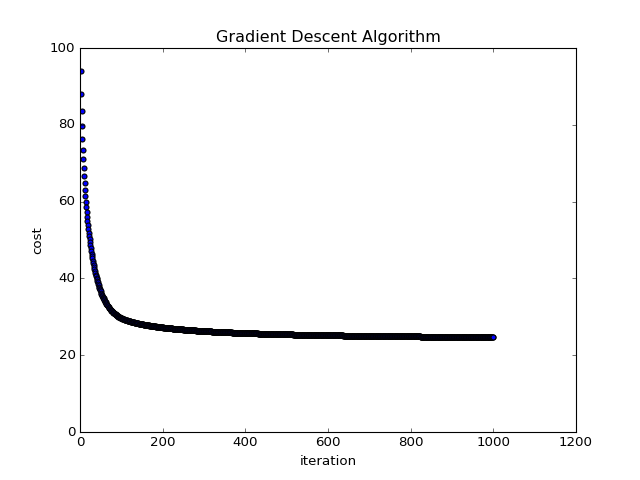

last coeffs:  [ 19.41168319  17.86574035   3.98372035] 24.7103423861


In [5]:
C = np.random.rand(3)*5.0 + 5.0 # [5, 10)
print('first coeffs: ', C, J(C))
(costs, C) = gradient_descent_algorithm(C, alpha=0.02, delta=0.0001, iteration=1000)
fig, ax = plt.subplots()
ax.scatter(range(0, len(costs)), costs)
ax.set_title('Gradient Descent Algorithm')
ax.set_xlabel('iteration')
ax.set_ylabel('cost')
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0, top=100.0)
plt.show()
print('last coeffs: ', C, J(C))

As we iterate, the cost is getting smaller. When we plot the height-time graph with randomly generated coefficients and the final coefficients we obtain out of the gradient descent algorithm, we observe the significant improvement. Animation is also helpful to demonstrate the improvement.

##  Genetic Algorithm for PID Tuning

Gradient descent algorithm notoriously suffers from the local minimum trap. Once it finds a local minimum, it can't go further to find a better solution. We have to run gradient descent algorithm multiple times, compare the results and pick the best solution out of them. That is where the genetic algorithm shines through.

We start with randomly generated individuals(i.e coefficients), then select two individuals and apply crossover operation to get a new individual. The new individual may undergo some mutations with a small probability factor.
Mutations are supposed to help the population dodge local minimum traps. A noticeable drawback of genetic algorithm is that a new individual might end up with a terrible cost, possibly the worst cost in the population.

In [6]:
## Fitness calculated using the cost function.
def fitness(individual):
    c = J(individual)
    f = 1.0/(c + 1.0)
    return (c, f)
    
# Best-fit and Roulette Wheel Selections
def select(population, fitnesses):
    cumulative = sum(fitnesses)

    index1 = fitnesses.index(max(fitnesses))
    index2 = 0
    s = 0
    r = np.random.rand() * cumulative # [0, cumulative)
    for i, f in enumerate(fitnesses):
        if s >= r:
            index2 = i
            break;
        s += f
    return (population[index1], population[index2])

# Three-point crossover
def crossover(individual1, individual2):
    individual = [0.0, 0.0, 0.0]
    r = np.random.rand()
    individual[0] = individual2[0]*r + individual1[0]*(1.0-r)
    r = np.random.rand()
    individual[1] = individual2[0]*r + individual1[1]*(1.0-r)
    r = np.random.rand()
    individual[2] = individual2[0]*r + individual1[2]*(1.0-r)
    return individual

# Muatation with probability of 5%
def mutate(individual):
    if np.random.randint(0, 100) < 5:
        i = np.random.randint(0, len(individual))
        k = np.random.rand()*2.5
        individual[i] *= k
    return individual
    
# Genetic algorithm loop
def genetic_algorithm(population, iteration=100):
    costs = [fitness(individual)[0] for individual in population]
    fitnesses = [fitness(individual)[1] for individual in population]
    for i in range(iteration):
        (individual1, individual2) = select(population, fitnesses)
        individual = crossover(individual1, individual2)
        individual = mutate(individual)
        (c, f) = fitness(individual)
        population.append(individual) 
        fitnesses.append(f)
        costs.append(c)
    return (costs, fitnesses, population[fitnesses.index(max(fitnesses))])

best:  [161.40858917220115, 24.677859777719057, 16.526127871556596] 23.4260490215


<IPython.core.display.Javascript object>


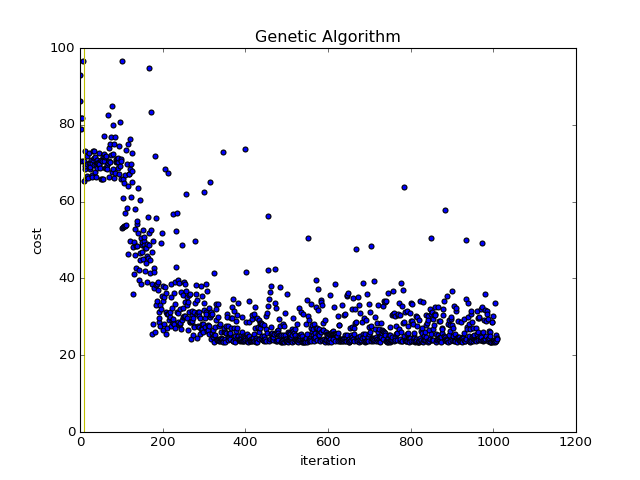

In [9]:
# Randomly generate individuals
population = (np.random.rand(10, 3)*5.0 + 5.0).tolist() # 3 individuals of coeffs range [5, 10)
(costs, fitnesses, best) = genetic_algorithm(population, iteration=1000)
print('best: ', best, (J(best)))
fig, ax = plt.subplots()
ax.scatter(range(0, len(costs)), costs)
ax.axvline(x=10, linewidth=1, color='y')
ax.set_title('Genetic Algorithm')
ax.set_xlabel('iteration')
ax.set_ylabel('cost')
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0, top=100.0)
plt.show()

## Concluding Remarks

- Physical systems have limits, as apposed to hypothetical ideal systems. We should avoid exceeding the limits. That is why integral windup guards are indispensable part of realistic PID controllers.

- PID tuning could be quite a tedious job. Gradient descent and genetic algorithms come in handy to automate it.

- Gradient descent algorithm is likely to fall into a local minimum and fails to explore better solutions.

- Genetic algorithm can avoid local minima, but might produce very costly individuals along the way.

In part 2, I am going to consider a cascading PID controller for the same system. The way it should work is an inner loop controls the velocity while an outer loop actually controls the height. Following diagram gives an insight about the cascading PID controllers.

![cascading-pid](../img/simple_lifter_pid_cascading.png)